# Trying it out for:
* fixed environment (constantly shifting focus so that the first agent is at center)
* Increased distance weights
* Additional features
* ...

In [4]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *
from utils.params import *

from importlib import reload
import utils
# reload(utils.ReplayMemory)
# reload(utils.networks)
# reload(utils.agents)
# reload(utils.plotting)
# reload(utils.train_test_methods)

input_type = U_VELOCITY
observe_type = O_VELOCITY
observe_action = O_ACTION
reward_mode=ALL_REWARD

## Try out Actor-Critic

In [ ]:
# Test out Actor-Critic methods. Note that tuning parameters might be required.
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=500#250#500
test_interval=10#0
num_test=10#50
num_iteration=200
BATCH_SIZE=128#64#128
save_sim_intv=50
debug=False
num_sample=50
seed=22222
hidden=32
action_space=[-1,1]

# rand_mode = NO_RAND
rand_mode = GAUSS_RAND

N_list = [5,10,20]
env_list = []
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05, #o_radius=40000,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, 
                 reward_mode=DIST_REWARD,#|ACT_REWARD,
#                  uses_boundary=True,
                 uses_boundary=False,
                 dist_reward_func=lambda x : (np.log(np.abs(x)+1)),
#                  dist_reward_func=lambda x : (np.sqrt(x) * 2),
#                  dist_reward_func=lambda x : (np.abs(x) + 2) * (np.abs(x) + 2),
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS
        ).unwrapped
    )
#     env_list[-1].mov_w = 100

AC2_list = []
for i,N_ in enumerate(N_list):
    AC2_list.append(
        AC2Agent(device, N_, env_list[i].nf, env_list[i].na, hidden, rand_modeA=rand_mode,
                 learning_rateA=0.01, learning_rateC=0.02, mode=1208)
    )

sim_fnames = ['AC2_dist_reward_posGauss_fixed0_d400_logdist_m1208_N{0}'.format(N_) for N_ in N_list]

AC2_hist = []
AC2_loss = []
for i,N_ in enumerate(N_list):
    AC2_loss.append([])
    AC2_hist.append(
        train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
#               update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, 
              update_mode=UPDATE_PER_EPISODE, reward_mode=FUTURE_REWARD_YES|FUTURE_REWARD_NORMALIZE,
              loss_history=AC2_loss[i],
              save_sim_intv=save_sim_intv, save_sim_fnames=[sim_fnames[i]], 
              imdir='screencaps/', useVid=False)
    )
    print("Finished training env with {0} agents for AC".format(N_))


In [ ]:
# additional testing
num_episode=1500
test_interval=5#0
num_test=10#50
num_iteration=200
N_list = [5,10,20]

for i,N_ in enumerate(N_list):
#     AC2_list[i].optimizerA.learning_rate = 0.05
#     AC2_list[i].optimizerC.learning_rate = 0.08
    AC2_hist[i] += train(AC2_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC2_loss[i])
    print("Finished training env with {0} agents for AC".format(N_))

for i,N_ in enumerate(N_list):
    AC2_test_hist[i] += plot_test(AC2_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    print("Finished testnig env with {0} agents for AC".format(N_))

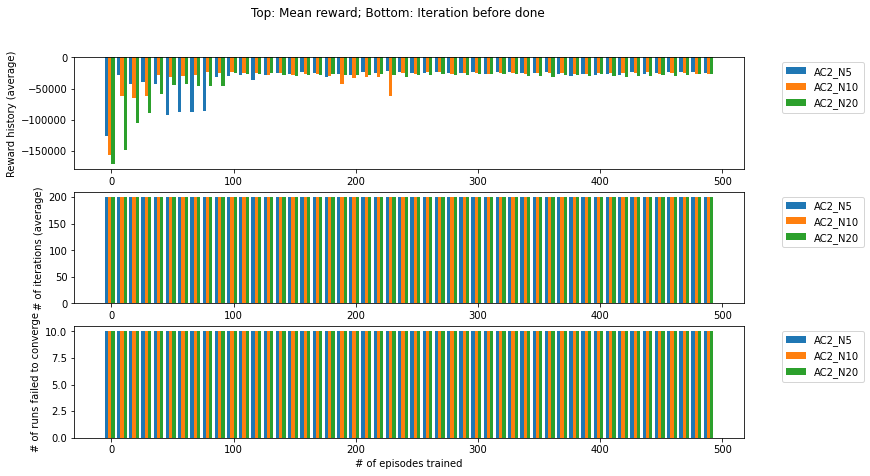

In [21]:
reload(utils.plotting)
from utils.plotting import *
skip = 1
plot_reward_hist([h[::skip] for h in AC2_hist], test_interval*skip, 
                 ['AC2_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list]), bar=True)

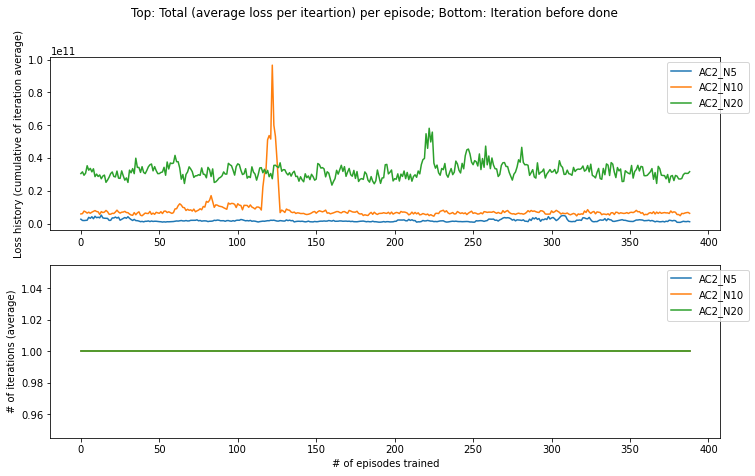

In [23]:
# Plot loss per # of agent
skip=1
plot_loss_hist(hists=[h[::skip] for h in AC2_loss], hist_names=['AC2_N{0}'.format(N_) for N_ in N_list], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [26]:
### Save their animations and see how they behave.
for i,N_ in enumerate(N_list):
    plot_test(AC2_list[i], env_list[i], fnames=[sim_fnames[i]+'_test{0}'.format(j) for j in range(1)],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug)

Trying to use a video recording (unfinished)


Error: Trying to write to monitor directory /tmp/ConsensusContEnv:ConsensusContEnv-v0 with existing monitor files: /tmp/ConsensusContEnv:ConsensusContEnv-v0/openaigym.manifest.0.77331.manifest.json.

 You should use a unique directory for each training run, or use 'force=True' to automatically clear previous monitor files.

In [24]:
# AC2_list[0].save_model("AC2_onlydistreward_PosGauss_softbound_normalized_N5")
# AC2_list[1].save_model("AC2_onlydistreward_PosGauss_softbound_normalized_N10")
# AC2_list[2].save_model("AC2_onlydistreward_PosGauss_softbound_normalized_N20")
for i,N_ in enumerate(N_list):
    AC2_list[i].save_model(sim_fnames[i])

Saving model to models/AC2Agent_AC2_dist_reward_posGauss_fixed0_d400_logdist_m1208_N5
Saving model to models/AC2Agent_AC2_dist_reward_posGauss_fixed0_d400_logdist_m1208_N10
Saving model to models/AC2Agent_AC2_dist_reward_posGauss_fixed0_d400_logdist_m1208_N20


In [10]:
env_list[0].start_radius

2

#### The above, but uses all reward terms together

In [93]:
num_episode=500
test_interval=10#0
num_test=10#50
BATCH_SIZE=128

env_list_allreward = []
N_list = [5,10,20]
for N_ in N_list:
    env_list_allreward.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=ALL_REWARD,
#                  uses_boundary=False,
                 uses_boundary=True,
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS#END_ON_CONSENSUS#REWARD_IF_CONSENSUS
        ).unwrapped
    )

AC2_list_allreward = []
for i,N_ in enumerate(N_list):
    AC2_list_allreward.append(
        AC2Agent(device, N_, env_list_allreward[i].nf, env_list_allreward[i].na, hidden, rand_modeA=rand_mode, 
                 learning_rateA=0.01, learning_rateC=0.02, mode=1208)
    )

sim_fnames = ['AC2_all_reward_posGauss_fixed0_m1208_N{0}'.format(N_) for N_ in N_list]

AC2_hist_allreward = []
AC2_loss_allreward = []
for i,N_ in enumerate(N_list):
    AC2_loss_allreward.append([])
    AC2_hist_allreward.append(
        train(AC2_list_allreward[i], env_list_allreward[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
#               update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, 
              update_mode=UPDATE_PER_EPISODE, reward_mode=FUTURE_REWARD_YES|FUTURE_REWARD_NORMALIZE,
              loss_history=AC2_loss_allreward[i],
              save_sim_intv=save_sim_intv, save_sim_fnames=[sim_fnames[i]], 
              imdir='screencaps/', useVid=False)
    )
    print("Finished training env with {0} agents for AC".format(N_))


/Users/zz/Documents/GT 20F/7000/GNN_experiments/utils/agents.py:670: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  lossC = torch.nn.functional.mse_loss(reward_batch.squeeze(), next_pred_reward * self.gamma - pred_reward)


Test result at episode  0 : 
Test result at episode  10 : 
Test result at episode  20 : 
Test result at episode  30 : 
Test result at episode  40 : 
Finished episode  0  with  199 ;
cumulative reward =  -1338377.7099360884
Test result at episode  50 : 
Test result at episode  60 : 
Test result at episode  70 : 
Test result at episode  80 : 
Test result at episode  90 : 
Finished episode  0  with  199 ;
cumulative reward =  -1335749.0832536416
Test result at episode  100 : 
Test result at episode  110 : 
Test result at episode  120 : 
Test result at episode  130 : 
Test result at episode  140 : 
Finished episode  0  with  199 ;
cumulative reward =  -1339361.8224094606
Test result at episode  150 : 
Test result at episode  160 : 
Test result at episode  170 : 
Test result at episode  180 : 
Test result at episode  190 : 
Finished episode  0  with  199 ;
cumulative reward =  -1335745.112743995
Test result at episode  200 : 
Test result at episode  210 : 
Test result at episode  220 : 
Tes

Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x17821d470>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 165, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 81, in close
    if self.isopen and sys.meta_path:
AttributeError: 'Viewer' object has no attribute 'isopen'
Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x17b1e3cf8>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 165, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering

Test result at episode  300 : 
Test result at episode  310 : 
Test result at episode  320 : 
Test result at episode  330 : 
Test result at episode  340 : 
Trying to use a video recording (unfinished)
Failed to save simulation at e=349


Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x183b289b0>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 165, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 81, in close
    if self.isopen and sys.meta_path:
AttributeError: 'Viewer' object has no attribute 'isopen'


Test result at episode  350 : 
Test result at episode  360 : 
Test result at episode  370 : 
Test result at episode  380 : 
Test result at episode  390 : 
Trying to use a video recording (unfinished)
Failed to save simulation at e=399


Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x183b289b0>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 165, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 81, in close
    if self.isopen and sys.meta_path:
AttributeError: 'Viewer' object has no attribute 'isopen'


Test result at episode  400 : 
Test result at episode  410 : 
Test result at episode  420 : 
Test result at episode  430 : 
Test result at episode  440 : 
Trying to use a video recording (unfinished)
Failed to save simulation at e=449


Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x183b289b0>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 165, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 81, in close
    if self.isopen and sys.meta_path:
AttributeError: 'Viewer' object has no attribute 'isopen'


Test result at episode  450 : 
Test result at episode  460 : 
Test result at episode  470 : 
Test result at episode  480 : 
Test result at episode  490 : 
Trying to use a video recording (unfinished)
Failed to save simulation at e=499
Finished training env with 20 agents for AC


Exception ignored in: <bound method Viewer.__del__ of <gym.envs.classic_control.rendering.Viewer object at 0x183b289b0>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 165, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 81, in close
    if self.isopen and sys.meta_path:
AttributeError: 'Viewer' object has no attribute 'isopen'


<Figure size 432x288 with 0 Axes>

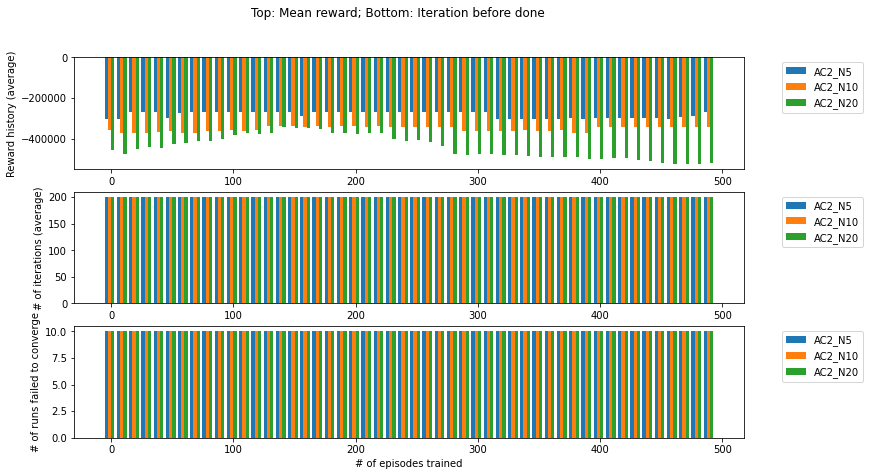

In [94]:
plot_reward_hist(AC2_hist_allreward, test_interval, 
                 ['AC2_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=([1 for N in N_list]), bar=True)

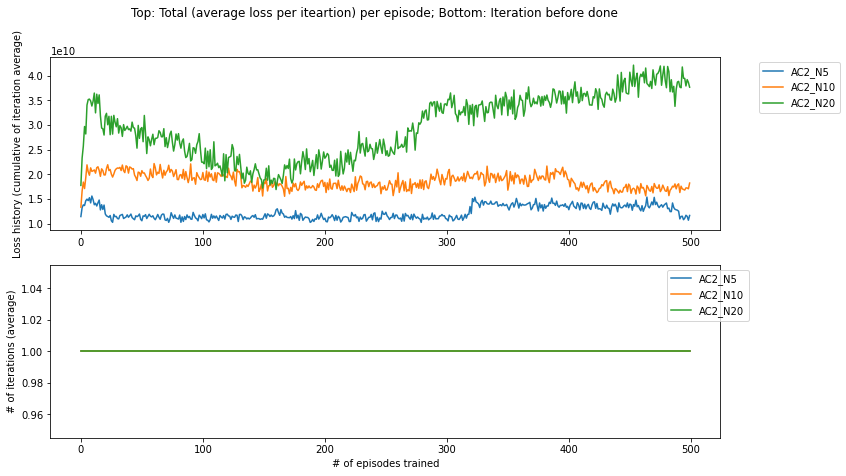

In [95]:
# Plot loss
plot_loss_hist(hists=[h[::skip] for h in AC2_loss_allreward], hist_names=['AC2_N{0}'.format(N_) for N_ in N_list], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [ ]:
for i,N_ in enumerate(N_list):
    AC2_list[i].save_model(sim_fnames[i])

In [ ]:
## Save their animations and see how they behave.
for i,N_ in enumerate(N_list):
    plot_test(AC2_list_allreward[i], env_list_allreward[i], fnames=[sim_fnames[i]+'_test{0}'.format(j) for j in range(1)],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug)

In [110]:
# Clear recorded histories
# AC2_hist_allreward = []
# AC2_loss_allreward = []

### Use advantage terms

In [90]:
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=250#500
test_interval=10#0
num_test=10#50
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50
seed=22222

N_list = [5,10,20]
env_list = []
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                 uses_boundary=False,
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS
        ).unwrapped
    )

AC3_list = []
for i,N_ in enumerate(N_list):
    AC3_list.append(
        AC3Agent(device, N_, env_list[i].nf, env_list[i].na, hidden, rand_modeA=rand_mode,
                 learning_rateA=0.01, learning_rateC=0.02, mode=0, gamma=0.98)
    )

sim_fnames3 = ['AC3_dist_reward_posGauss_fixed0_m0000_N{0}'.format(N_) for N_ in N_list]

AC3_hist = []
AC3_loss = []
for i,N_ in enumerate(N_list):
    AC3_loss.append([])
    AC3_hist.append(
        train(AC3_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
#               update_mode=UPDATE_PER_EPISODE, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC3_loss[i],
              update_mode=UPDATE_PER_EPISODE, reward_mode=FUTURE_REWARD_YES|FUTURE_REWARD_NORMALIZE,
              loss_history=AC3_loss[i],
              save_sim_intv=save_sim_intv, save_sim_fnames=[sim_fnames3[i]], 
              imdir='screencaps/', useVid=False)
    )
    print("Finished training env with {0} agents for AC".format(N_))

Test result at episode  0 : 
Test result at episode  10 : 
Test result at episode  20 : 
Test result at episode  30 : 
Test result at episode  40 : 
Finished episode  0  with  199 ;
cumulative reward =  -259446.31879547946
Test result at episode  50 : 
Test result at episode  60 : 
Test result at episode  70 : 
Test result at episode  80 : 
Test result at episode  90 : 
Finished episode  0  with  199 ;
cumulative reward =  -254814.26232101585
Test result at episode  100 : 
Test result at episode  110 : 
Test result at episode  120 : 
Test result at episode  130 : 
Test result at episode  140 : 
Finished episode  0  with  199 ;
cumulative reward =  -251137.89757024933
Test result at episode  150 : 
Test result at episode  160 : 
Test result at episode  170 : 
Test result at episode  180 : 
Test result at episode  190 : 
Finished episode  0  with  199 ;
cumulative reward =  -253696.79207723928
Test result at episode  200 : 
Test result at episode  210 : 
Test result at episode  220 : 
Te

<Figure size 432x288 with 0 Axes>

In [16]:
AC3_sb_list = AC3_list

In [ ]:
# Keep training
num_episode=1000
test_interval=10
num_test=10
num_iteration=200

# N_list = [5,10,20]
# env_list = []
# for N_ in N_list:
#     env_list.append(
#         gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
#               input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD
#         ).unwrapped
#     )

for i,N_ in enumerate(N_list):
#     AC3_list[i].optimizerA.learning_rate = 0.05
#     AC3_list[i].optimizerC.learning_rate = 0.08
    AC3_hist[i] += train(AC3_list[i], env_list[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC3_loss[i])
    print("Finished training env with {0} agents for AC".format(N_))

for i,N_ in enumerate(N_list):
    AC3_test_hist[i] += plot_test(AC3_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    print("Finished testnig env with {0} agents for AC".format(N_))

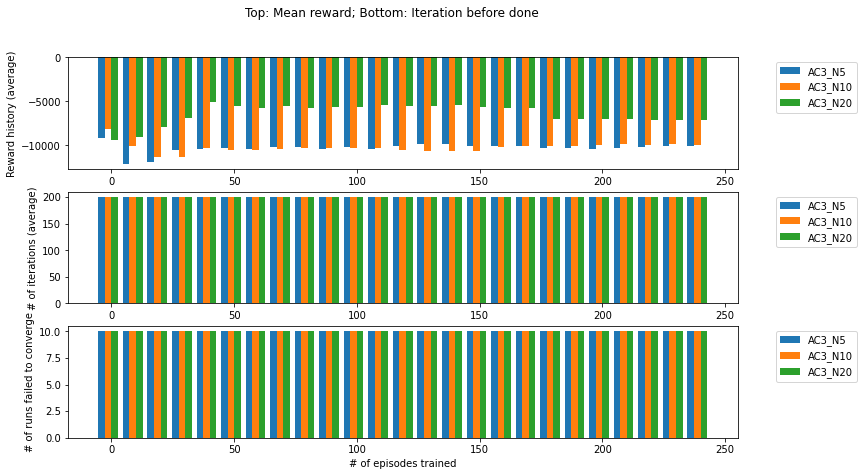

In [91]:
skip=1
plot_reward_hist([h[::skip] for h in AC3_hist], test_interval*skip, 
                 ['AC3_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list]), bar=True)

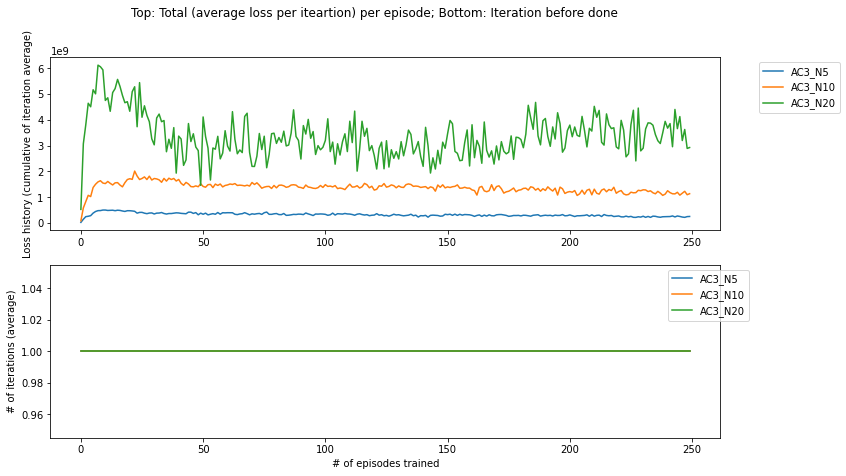

In [92]:
# Plot loss per # of agent
skip=1
plot_loss_hist(hists=[h[::skip] for h in AC3_loss], hist_names=['AC3_N{0}'.format(N_) for N_ in N_list], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [89]:
# AC3_list[0].save_model("AC3_onlydistreward_NegGauss_softbound_normalized_N5")
# AC3_list[1].save_model("AC3_onlydistreward_NegGauss_softbound_normalized_N10")
# AC3_list[2].save_model("AC3_onlydistreward_NegGauss_softbound_normalized_N20")

# AC3_list[0].save_model("AC3_onlydistreward_NegGauss_fixed0_normalized_N5")
# AC3_list[1].save_model("AC3_onlydistreward_NegGauss_fixed0_normalized_N10")
# AC3_list[2].save_model("AC3_onlydistreward_NegGauss_fixed0_normalized_N20")
for i,N_ in enumerate(N_list):
    AC3_list[i].save_model(sim_fnames3[i])

Saving model to models/AC3Agent_AC3_dist_reward_posGauss_fixed0_m1205_N5
Saving model to models/AC3Agent_AC3_dist_reward_posGauss_fixed0_m1205_N10
Saving model to models/AC3Agent_AC3_dist_reward_posGauss_fixed0_m1205_N20


In [12]:
### Save their animations and see how they behave.
for i,env_ in enumerate(env_list):
    plot_test(AC3_list[i], env_, fnames=[sim_fnames3[i]+'_test{0}'.format(j) for j in range(1)],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug)

Finished episode  0  with  99 ;
cumulative reward =  -11432.656454471153
Finished episode  0  with  99 ;
cumulative reward =  -45939.89173822266
Finished episode  0  with  99 ;
cumulative reward =  -155911.38261145438


<Figure size 432x288 with 0 Axes>

#### The above, but with all reward terms

In [ ]:
num_episode=500
test_interval=10#0
num_test=10#50
env_list_allreward = []
N_list = [5,10,20]
for N_ in N_list:
    env_list_allreward.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=ALL_REWARD,
#                  uses_boundary=False,
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=END_ON_CONSENSUS#REWARD_IF_CONSENSUS
        ).unwrapped
    )

AC3_list_allreward = []
for i,N_ in enumerate(N_list):
    AC3_list_allreward.append(
        AC2Agent(device, N_, env_list_allreward[i].nf, env_list_allreward[i].na, hidden, 
                 learning_rateA=0.01, learning_rateC=0.02)
    )

AC3_hist_allreward = []
AC3_loss_allreward = []
for i,N_ in enumerate(N_list):
    AC3_loss_allreward.append([])
    AC3_hist_allreward.append(
        train(AC3_list_allreward[i], env_list_allreward[i], 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC3_loss_allreward[i])
    )
    print("Finished training env with {0} agents for AC".format(N_))

In [ ]:
skip = 1
plot_reward_hist([h[2::skip] for h in AC3_hist_allreward], test_interval*skip, 
                 ['AC3_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=([1 for N in N_list]), bar=False)

In [ ]:
# Plot loss
skip=1
plot_loss_hist(hists=[h[5::skip] for h in AC3_loss_allreward], hist_names=['AC3_N{0}'.format(N_) for N_ in N_list], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [ ]:
AC3_list_allreward[0].save_model("AC3_allreward_normalized_N5")
AC3_list_allreward[1].save_model("AC3_allreward_normalized_N10")
AC3_list_allreward[2].save_model("AC3_allreward_normalized_N20")

In [ ]:
reload(utils.plotting)
from utils.plotting import *
### Save their animations and see how they behave.
for i,N_ in enumerate(N_list):
    plot_test(AC3_list[i], env_list[i], fnames=['AC3_dist_reward_test{0}_N{1}'.format(j,N_) for j in range(1)],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug)

In [111]:
# Clear some histories
# AC3_hist_allreward = []
# AC3_loss_allreward = []

### Try out AC with more interesting reward options

In [ ]:
# Test out Actor-Critic methods. Note that tuning parameters might be required.
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=500
test_interval=10#0
num_test=10#50
num_iteration=200
BATCH_SIZE=64#128
debug=False
num_sample=50
seed=22222

N_listv = [5,10]#,20]
env_listv = []
for N_ in N_listv:
    # Distance-based reward only, with hard penalty on touching the boundary.
    # Control group that doesn't give surviving reward, and instead stops immediately.
    env_listv.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD
        ).unwrapped
    )
    # Drop-dead immediately on touching the boundary
    env_listv.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                 boundary_policy=DEAD_ON_TOUCH
        ).unwrapped
    )
    # Hard penalty on boundary, coupled with positive convergence reward. This means it never stops on consensus.
    env_listv.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD, 
                 finish_reward_policy=REWARD_IF_CONSENSUS
        ).unwrapped
    )
    # Soft penalty with consensus rewards. I don't expect it to successfully discover
    # achieving consensus would bring reward, though.
    env_listv.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS
        ).unwrapped
    )
    # Comparison group that uses dist and actuation rewards, with hard penalty
    env_listv.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, 
                 reward_mode=(DIST_REWARD|ACT_REWARD)
        ).unwrapped
    )

labels = ['hard_bound_zero_posReward', 
          'dead_bound_zero_posReward', 
          'hard_bound_cumu_posReward', 
          'soft_bound_cumu_posReward', 
          'hard_bound_zero_posReward_v_penalty']*2
labels = [labels[i]+'_N{0}'.format(env_.N) for i,env_ in enumerate(env_listv)]

AC2_listv = []
for i,env_ in enumerate(env_listv):
    AC2_listv.append(
        AC2Agent(device, env_.N, env_.nf, env_.na, hidden, rand_modeA=rand_mode,
                 learning_rateA=0.01, learning_rateC=0.02)
    )

AC2_histv = []
AC2_lossv = []
for i,env_ in enumerate(env_listv):
    AC2_lossv.append([])
    AC2_histv.append(
        train(AC2_listv[i], env_, 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
#               update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC2_loss[i])
              # Using normalization might ruine the effort?
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC2_lossv[i])
    )
    print("Finished training env with {0} agents for AC".format(env_.N))

In [ ]:
# additional training
num_episode=500
test_interval=10
num_test=10#50
num_iteration=200

for i,env_ in enumerate(env_listv):
    AC2_listv[i].optimizerA.learning_rate = 0.1
    AC2_listv[i].optimizerC.learning_rate = 0.1
    AC2_histv[i] += train(AC2_listv[i], env_, 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC2_lossv[i])
    print("Finished training "+labels[i])


In [ ]:
reload(utils.plotting)
from utils.plotting import *

skip = 1
i = 9
plot_reward_hist([AC2_histv[i][::skip]], test_interval*skip, 
                 [labels[i]], # ['AC2_N{0}'.format(env_list[i].N)], 
                 log=False, num_iteration=num_iteration, 
                 N_list=[env_listv[i].N], # ([1 for env_ in env_list]), 
                 bar=True)

In [ ]:
# Plot loss per # of agent
skip=1
# i = 0
# plot_loss_hist(hists=[AC2_loss[i][::skip]], 
#                hist_names=[labels[i]], 
#                log=False, num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=True)
plot_loss_hist(hists=[h[::skip] for h in AC2_lossv], hist_names=labels, 
               log=False, num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [ ]:
for i,lab in enumerate(labels):
    AC2_listv[i].save_model("AC2_GaussTest_distreward_normalized_"+lab)

In [ ]:
### Save their animations and see how they behave.
for i,env_ in enumerate(env_listv):
    plot_test(AC2_listv[i], env_, fnames=['AC2_distreward_normalized'+labels[i]+'_test{0}'.format(j) for j in range(1)],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug)

### Try using Additive noise instead of Gaussian or noise-free
The environment reward configs here are slightly different from the ones above

In [ ]:
# Test out Actor-Critic with noise
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=500
test_interval=10
num_test=10#50
num_iteration=200

N_list = [5,10,20]
env_listr = []
for N_ in N_list:
    # Distance-based reward only, with hard penalty on touching the boundary.
    # Control group that doesn't give surviving reward, and instead stops immediately.
    env_listr.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD
        ).unwrapped
    )
    # Drop-dead immediately on touching the boundary
    env_listr.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                 boundary_policy=DEAD_ON_TOUCH
        ).unwrapped
    )
    # Hard penalty on boundary, coupled with positive convergence reward. This means it never stops on consensus.
    env_listr.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD, 
                 finish_reward_policy=REWARD_IF_CONSENSUS
        ).unwrapped
    )
    # Soft penalty with consensus rewards. I don't expect it to successfully discover
    # achieving consensus would bring reward, though.
    env_listr.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS
        ).unwrapped
    )
    # Comparison group that uses dist and actuation rewards, with hard penalty
    env_listr.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, 
                 reward_mode=(DIST_REWARD|ACT_REWARD)
        ).unwrapped
    )

AC2_listr = []
for i,env_ in enumerate(env_listr):
    AC2_listr.append(
        AC2Agent(device, env_.N, env_.nf, env_.na, hidden, add_noise=True,
                 learning_rateA=0.01, learning_rateC=0.02)
    )

AC2_histr = []
AC2_lossr = []
for i,env_ in enumerate(env_listr):
    AC2_lossr.append([])
    AC2_histr.append(
        train(AC2_listr[i], env_, 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
#               update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC2_loss[i])
              # Using normalization might ruine the effort?
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC2_lossr[i])
    )
    print("Finished training env with {0} agents for AC".format(env_.N))

In [ ]:
# additional training
num_episode=500
test_interval=10
num_test=10#50
num_iteration=200

for i,env_ in enumerate(env_listr):
    AC2_listr[i].optimizerA.learning_rate = 0.1
    AC2_listr[i].optimizerC.learning_rate = 0.1
    AC2_histr[i] += train(AC2_listr[i], env_, 
              num_episode=num_episode, test_interval=test_interval, num_test=num_test, num_iteration=num_iteration, 
              BATCH_SIZE=BATCH_SIZE, num_sample=num_sample, action_space=[-1,1], debug=debug,
              update_mode=UPDATE_PER_ITERATION, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=AC2_lossr[i])
    print("Finished training "+labels[i])


In [ ]:
skip = 1
i = 4
plot_reward_hist([AC2_histr[i][::skip]], test_interval*skip, 
                 [labels[i]], # ['AC2_N{0}'.format(env_list[i].N)], 
                 log=False, num_iteration=num_iteration, 
                 N_list=[env_listr[i].N], # ([1 for env_ in env_list]), 
                 bar=True)

In [ ]:
# Plot loss per # of agent
skip=1
# i = 0
# plot_loss_hist(hists=[AC2_lossr[i][::skip]], 
#                hist_names=[labels[i]], 
#                log=False, num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=True)
plot_loss_hist(hists=[h[::skip] for h in AC2_lossr], hist_names=labels, 
               log=False, num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION, bar=False)

In [ ]:
for i,lab in enumerate(labels[:5]):
    AC2_listr[i].save_model("AC2_randnoise_distreward_normalized_"+lab)

In [ ]:
### Save their animations and see how they behave.
for i,env_ in enumerate(env_listr):
    plot_test(AC2_listr[i], env_, fnames=['AC2_noise_distreward_normalized'+labels[i]+'_test{0}'.format(j) for j in range(2)],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug)

### DDPG

In [ ]:
reload(utils.agents)
from utils.agents import *

num_episode=500
test_interval=50
num_test=50
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50

# Do DDPG
DDPG_list = []
for i,N_ in enumerate(N_list):
    DDPG_list.append(
        DDPGAgent(device, N_, env_list[i].no, env_list[i].na, hidden)
    )
DDPG_list.append(
    DDPGAgent(device, 10, env.no, env.na, hidden)
)

DDPG_hist = []
for i,N_ in enumerate(N_list):
    DDPG_hist.append(
        train(DDPG_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for AC".format(N_))
DDPG_hist.append(
    train(DDPG_list[-1], env, 
          num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
)
    
DDPG_test_hist = []
for i,N_ in enumerate(N_list):
    DDPG_test_hist.append(
        plot_test(DDPG_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
DDPG_test_hist.append(
    plot_test(DDPG_list[-1], env, fnames=['']*num_test,
        num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
)

In [ ]:

DDPG_test_hist = []
for i,N_ in enumerate(N_list):
    DDPG_test_hist.append(
        plot_test(DDPG_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
DDPG_test_hist.append(
    plot_test(DDPG_list[-1], env, fnames=['']*num_test,
        num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
)

In [ ]:
plot_reward_hist(DDPG_hist, test_interval, 
                 ['DDPG_N{0}'.format(N_) for N_ in N_list]+['DDPG_N10'], 
                 log=False, num_iteration=num_iteration, N_list=([np.sqrt(N) for N in N_list]+[np.sqrt(10)])*2)

In [ ]:
plot_reward_hist([[l] for l in DDPG_test_hist], test_interval, 
                 ['DDPG_N{0}'.format(N_) for N_ in N_list]+['DDPG_N10'], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list]+[10])*2)

In [ ]:

def save_model(agent, suffix="", agent_path=None):
    if not os.path.exists('models/'):
        os.makedirs('models/')

    if len(suffix) <= 0:
        suffix = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    if agent_path is None:
        agent_path = "models/{}_{}".format(agent.name, suffix)
    print('Saving model to {}'.format(agent_path))
    torch.save(agent.netA.state_dict(), agent_path+"_A")
    torch.save(agent.netC.state_dict(), agent_path+"_C")
    
for i,N_ in enumerate(N_list+[10]):
    save_model(AC2_list[i],'AC2_test2_N{0}'.format(N_))
    
def save_model(agent, suffix="", agent_path=None):
    if not os.path.exists('models/'):
        os.makedirs('models/')

    if len(suffix) <= 0:
        suffix = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    if agent_path is None:
        agent_path = "models/{}_{}".format(agent.name, suffix)
    print('Saving model to {}'.format(agent_path))
    torch.save(agent.netA.state_dict(), agent_path+"_A")
    torch.save(agent.netC.state_dict(), agent_path+"_C")
    torch.save(agent.netAT.state_dict(), agent_path+"_AT")
    torch.save(agent.netCT.state_dict(), agent_path+"_CT")
    
for i,N_ in enumerate(N_list+[10]):
    save_model(DDPG_list[i],'DDPG_test2_N{0}'.format(N_))

### Test out different training setups and compare
using the new reward

In [ ]:
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

num_episode=250
test_interval=25
num_test=25
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50
transfer_num_episode=200
seed=2333333

# Bulid environments with different number of agents
env_list = []
env5_list = []
N_list = [5]#, 10, 20, 32]#, 50, 64]
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_NO_ACTION
        ).unwrapped
    )
    env5_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION
        ).unwrapped
    )

# Initialize 4 different groups of agents
# Type 1: Learn from scratch using cumulative reward 
RA_cumu_list = []
# Type 2: Learn from scratch using non-cumulative reward 
RA_inst_list = []
# Type 3: Learn from scratch using normalized cumulative reward 
RA_norm_list = []
# Type 4: Transfer learning to the new environment from models saved using old reward function
RA_trsf_list = []
RApath = 'models/RewardAgent_RA32_master_agent'
prevN = 32
# Type 4, v2: Trans train using cumulative reward
RA_trfc_list = []
# Type 5: Learn while observing others' past actions
RA_obac_list = []

for i,N_ in enumerate(N_list):
    RA_cumu_list.append(
        RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden, learning_rate=0.1)
    )
    RA_inst_list.append(
        RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden, learning_rate=0.1)
    )
    RA_norm_list.append(
        RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden, learning_rate=0.1)
    )
    RA_trsf_list.append(
        RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden, learning_rate=0.1, prevN=prevN, load_path=RApath)
    )
    RA_trfc_list.append(
        RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden, learning_rate=0.1, prevN=prevN, load_path=RApath)
    )
    RA_obac_list.append(
        RewardAgent(device, N_, env5_list[i].nf, env_list[i].na, hidden, learning_rate=0.1)
    )

In [ ]:
# Train those agents one by one, I guess
RA_cumu_hists = []
RA_inst_hists = []
RA_norm_hists = []
RA_trsf_hists = []
RA_obac_hists = []
RA_cumu_lossess = [[] for i in N_list]
RA_inst_lossess = [[] for i in N_list]
RA_norm_lossess = [[] for i in N_list]
RA_trsf_lossess = [[] for i in N_list]
RA_obac_lossess = [[] for i in N_list]
RA_trfc_lossess = [[] for i in N_list]
RA_cumu_lr_hist = [[] for i in N_list]
RA_inst_lr_hist = [[] for i in N_list]
RA_norm_lr_hist = [[] for i in N_list]
RA_trsf_lr_hist = [[] for i in N_list]
RA_obac_lr_hist = [[] for i in N_list]
RA_trfc_lr_hist = [[] for i in N_list]
for i,N_ in enumerate(N_list):
    RA_cumu_hists.append(
        train(RA_cumu_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_YES, loss_history=RA_cumu_lossess[i], lr_history=RA_cumu_lr_hist[i]
        )
    )
    RA_inst_hists.append(
        train(RA_inst_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_NO, loss_history=RA_inst_lossess[i], lr_history=RA_inst_lr_hist[i]
        )
    )
    RA_norm_hists.append(
        train(RA_norm_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=RA_norm_lossess[i], lr_history=RA_norm_lr_hist[i]
        )
    )
    RA_trsf_hists.append(
        train(RA_trsf_list[i], env_list[i], 
              transfer_num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_NO, loss_history=RA_trsf_lossess[i], lr_history=RA_trsf_lr_hist[i]
        )
    )
    RA_obac_hists.append(
        train(RA_obac_list[i], env5_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_YES, loss_history=RA_obac_lossess[i], lr_history=RA_obac_lr_hist[i]
        )
    )
    RA_trfc_hists.append(
        train(RA_trfc_list[i], env_list[i], 
              transfer_num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_YES, loss_history=RA_trfc_lossess[i], lr_history=RA_trfc_lr_hist[i]
        )
    )
    print("Finished training env with {0} agents for RA".format(N_))

In [ ]:
num_episode=250
for i,N_ in enumerate(N_list):
    RA_cumu_hists[i]+=train(RA_cumu_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_YES, loss_history=RA_cumu_lossess[i]
        )
    
    RA_inst_hists[i]+=train(RA_inst_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_NO, loss_history=RA_inst_lossess[i]
        )
    
    RA_norm_hists[i]+=train(RA_norm_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_YES_NORMALIZE, loss_history=RA_norm_lossess[i]
        )
    

In [ ]:
RA_trfc_hists = []
for i,N_ in enumerate(N_list):
    RA_trfc_hists.append(
        train(RA_trfc_list[i], env_list[i], 
              transfer_num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
              seed=seed, reward_mode=FUTURE_REWARD_YES
        )
    )

In [ ]:
for i,N_ in enumerate(N_list):
    RA_cumu_list[i].save_model('rewardV2_N{0}_cumu_test1'.format(N_))
    RA_inst_list[i].save_model('rewardV2_N{0}_inst_test1'.format(N_))
    RA_norm_list[i].save_model('rewardV2_N{0}_norm_test1'.format(N_))
    RA_trsf_list[i].save_model('rewardV2_N{0}_trsf_test1'.format(N_))
    RA_obac_list[i].save_model('rewardV2_N{0}_obac_test1'.format(N_))
    RA_trfc_list[i].save_model('rewardV2_N{0}_trfc_test1'.format(N_))

In [ ]:
# Plot per group
comb_hists = [RA_cumu_hists,RA_inst_hists,RA_norm_hists,RA_trsf_hists,RA_trfc_hists,RA_obac_hists]
comb_names = [['RA_{1}_N{0}'.format(N_,name) for N_ in N_list] for name in [
    'cum_reward','no_cum_reward','cum_norm_reward','tf_no_cum','tf_cum_reward','observe_action_cum']]
i = 5
plot_reward_hist(comb_hists[i], test_interval, 
                 comb_names[i], 
                 log=False, num_iteration=num_iteration, N_list=[1 for N_ in N_list])

In [ ]:
# Plot per # of agent
cumb_hists = [[RA_cumu_hists[i],RA_inst_hists[i],RA_norm_hists[i],
               RA_trsf_hists[i],RA_trfc_hists[i],RA_obac_hists[i]] for i in range(len(N_list))]
cumb_names = [['RA_{1}_N{0}'.format(N_,name) for name in [
    'cum_reward','no_cum_reward','cum_norm_reward','tf_no_cum','tf_cum_reward','observe_action_cum']] for N_ in N_list]
j = 3
plot_reward_hist(cumb_hists[j], test_interval, 
                 cumb_names[j], 
                 log=False, num_iteration=num_iteration, N_list=[N_list[j]]*6)

In [ ]:
reload(utils.plotting)
from utils.plotting import *
# Plot loss per # of agent
cumb_hists = [[RA_cumu_lossess[i],RA_inst_lossess[i],RA_norm_lossess[i],
               RA_trsf_lossess[i],RA_trfc_lossess[i],RA_obac_lossess[i]] for i in range(len(N_list))]
cumb_names = [['RA_{1}_N{0}'.format(N_,name) for name in [
    'cum_reward','no_cum_reward','cum_norm_reward','tf_no_cum','tf_cum_reward','observe_action_cum']] for N_ in N_list]

j = 0
plot_loss_hist(hists=cumb_hists[j], hist_names=cumb_names[j], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION)

### How about using CNN?

In [ ]:
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

num_episode=500
test_interval=25
num_test=25
num_iteration=200
BATCH_SIZE=256
debug=False
num_sample=50
seed=2333333
hidden=8

NCN_list = [5,10] 
envCNN_list = []
for N_ in NCN_list:
    envCNN_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION
        ).unwrapped
    )
LA_CNN_list = []
RA_CNN_list = []
for i,N_ in enumerate(NCN_list):
    LA_CNN_list.append(
        LearnerCNNAgent(device, N_, ns=envCNN_list[i].nf, na=env_list[i].na, hidden=hidden, n_hid=2, in_features=1)
    )
    RA_CNN_list.append(
        RewardCNNAgent(device, N_, ns=envCNN_list[i].nf, na=env_list[i].na, hidden=hidden, n_hid=2, in_features=1)
    )
LA_CNN_hists = []
RA_CNN_hists = []
for i,N_ in enumerate(NCN_list):
    LA_CNN_hists.append(
        train(LA_CNN_list[i], envCNN_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
                             seed=seed, reward_mode=FUTURE_REWARD_YES, update_mode=UPDATE_PER_EPISODE)
    )
    RA_CNN_hists.append(
        train(RA_CNN_list[i], envCNN_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
                             seed=seed, reward_mode=FUTURE_REWARD_YES, update_mode=UPDATE_PER_EPISODE)
    )
    print("Finished training env with {0} agents for CNN".format(N_))

In [ ]:
# Keep training those lazy gradients
num_episode=2600
test_interval=20
num_test=25
num_iteration=200
BATCH_SIZE=256
debug=False
num_sample=50
seed=2333333
hidden=8

for i,N_ in enumerate(NCN_list):
    LA_CNN_hists[i] += train(LA_CNN_list[i], envCNN_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
                             seed=seed, reward_mode=FUTURE_REWARD_YES)
    RA_CNN_hists[i] += train(RA_CNN_list[i], envCNN_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
                             seed=seed, reward_mode=FUTURE_REWARD_YES)
    print("Finished training env with {0} agents for CNN".format(N_))

In [ ]:
# Plot results
plot_reward_hist(LA_CNN_hists, test_interval, ['LA_CNN_N{0}'.format(N_) for N_ in NCN_list], 
                 log=False, num_iteration=num_iteration, N_list=[1 for N_ in NCN_list])

In [ ]:
plot_reward_hist(RA_CNN_hists, test_interval, ['RA_CNN_N{0}'.format(N_) for N_ in NCN_list], 
                 log=False, num_iteration=num_iteration, N_list=[1 for N_ in NCN_list])

In [ ]:
LA_CNN_list[0].save_model("LA_CNN_test1_3000epi_N5")
LA_CNN_list[1].save_model("LA_CNN_test1_3000epi_N10")
RA_CNN_list[0].save_model("RA_CNN_test1_3000epi_N5")
RA_CNN_list[1].save_model("LA_CNN_test1_3000epi_N10")

In [ ]:
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

# Additional training and testing and probing
num_episode=1#200
test_interval=20
num_test=1#25
num_iteration=200
BATCH_SIZE=32
debug=False
num_sample=50
seed=2333333
hidden=8

i = 0
N_ = 5
LCtest = LearnerCNNAgent(device, N_, ns=envCNN_list[i].nf, na=env_list[i].na, hidden=hidden, n_hid=2, in_features=1)
RCtest = RewardCNNAgent(device, N_, ns=envCNN_list[i].nf, na=env_list[i].na, hidden=hidden, n_hid=2, in_features=1)

LCtesth = train(LCtest, envCNN_list[i], 
          num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
RCtesth = train(RCtest, envCNN_list[i], 
          num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
print("Finished training env with {0} agents for CNN".format(N_))

### How about trying ResNet or similar structure?

In [ ]:
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

num_episode=50
test_interval=5
num_test=10#25
num_iteration=50#200
BATCH_SIZE=64
debug=False
num_sample=50
seed=2333333

NCN_list = [5] 
envCNN_list = []
for N_ in NCN_list:
    envCNN_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION
        ).unwrapped
    )
RA_RN_list = []
for i,N_ in enumerate(NCN_list):
    RA_RN_list.append(
        RewardRNAgent(device, N_, ns=envCNN_list[i].nf, na=env_list[i].na, n_hid=2, in_features=1)
    )
RA_RN_hists = []
RA_RN_lossess=[]
for i,N_ in enumerate(NCN_list):
    RA_RN_hists.append(
        train(RA_RN_list[i], envCNN_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
                             seed=seed, reward_mode=FUTURE_REWARD_YES, update_mode=UPDATE_PER_EPISODE,
                             loss_history=RA_RN_lossess)
    )
    print("Finished training env with {0} agents for RN".format(N_))

In [ ]:
# Plot per # of agent
plot_reward_hist(RA_RN_hists, test_interval, ['RA_ResNet_N5'], 
                 log=False, num_iteration=num_iteration, N_list=NCN_list)

In [ ]:
reload(utils.plotting)
from utils.plotting import *
# Plot loss per # of agent
plot_loss_hist(hists=[RA_RN_lossess], hist_names=['RA_ResNet_N5'], log=False, 
               num_iteration=num_iteration, update_mode=UPDATE_PER_ITERATION)

### Load existing models and see their training results

In [3]:
# Note: To do this, you'll first need to create the corresponding environment, and call them in the correct network configuration.
# Use agent.load_model()
# import utils.retrieve_sim
# reload(utils)
# reload(utils.retrieve_sim)
from utils.retrieve_sim import *

import os
try:
    os.mkdir('screencaps')
except:
    pass

input_type = U_VELOCITY
observe_type = O_VELOCITY
observe_action = O_ACTION
reward_mode=ALL_REWARD

hidden=32
action_space=[-1,1]

# rand_mode = NO_RAND
rand_mode = GAUSS_RAND

N_list = [2,5,10]
iter_of_interest = [ '_249', '_499', '_749', '_899', '_999']
for N in N_list:
    N_pf = '_N{0}'.format(N)
    env2 = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N, dt=0.1, Delta=0.05, #o_radius=40000,
                  input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                     boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS, 
                     uses_boundary=False
    #                  uses_boundary=True
            ).unwrapped
    AC2template = AC2Agent(device, env2.N, env2.nf, env2.na, hidden, rand_modeA=rand_mode,
                     learning_rateA=0.01, learning_rateC=0.02, mode=1208)
    model_names = grab_model_names('AC2Agent_AC2_dist_reward_posGauss_fixed0_m1208_s')
    model_names = [mn for mn in model_names if mn[-4:] in iter_of_interest and \
                                               mn[-(4+len(N_pf)):-4] == N_pf]
    run_sims_for_models(
        model_names,
        AC2template, env2
    )

Loading model from models/AC2Agent_AC2_dist_reward_posGauss_fixed0_m1208_soft_bound_cumu_posReward_N2_249
Finished episode  0  with  99 ;
cumulative reward =  -28321.16050572795
saved gif into  AC2Agent_AC2_dist_reward_posGauss_fixed0_m1208_soft_bound_cumu_posReward_N2_249.gif
Loading model from models/AC2Agent_AC2_dist_reward_posGauss_fixed0_m1208_soft_bound_cumu_posReward_N2_499
Finished episode  0  with  99 ;
cumulative reward =  -29285.138585469387
saved gif into  AC2Agent_AC2_dist_reward_posGauss_fixed0_m1208_soft_bound_cumu_posReward_N2_499.gif
Loading model from models/AC2Agent_AC2_dist_reward_posGauss_fixed0_m1208_soft_bound_cumu_posReward_N2_749
Finished episode  0  with  99 ;
cumulative reward =  -53382.873640988146
saved gif into  AC2Agent_AC2_dist_reward_posGauss_fixed0_m1208_soft_bound_cumu_posReward_N2_749.gif
Loading model from models/AC2Agent_AC2_dist_reward_posGauss_fixed0_m1208_sqrt_reward_N2_249
Finished episode  0  with  99 ;
cumulative reward =  -54205.8717165717
s

<Figure size 432x288 with 0 Axes>

In [32]:
from utils.retrieve_sim import *

input_type = U_VELOCITY
observe_type = O_VELOCITY
observe_action = O_ACTION
reward_mode=ALL_REWARD

hidden=32
action_space=[-1,1]

# rand_mode = NO_RAND
rand_mode = GAUSS_RAND

env2K = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=10, dt=0.1, Delta=0.05, o_radius=40000,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS, 
                 uses_boundary=False
#                  uses_boundary=True
        ).unwrapped
env2 = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=10, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS, 
                 uses_boundary=False
        ).unwrapped

ACmode = 1204
AC2template = AC2Agent(device, env2.N, env2.nf, env2.na, hidden, rand_modeA=rand_mode,
                 learning_rateA=0.01, learning_rateC=0.02, mode=ACmode)

model_names = grab_model_names('AC3Agent_AC3_dist_reward_negGauss_test007_K') # AC3Agent_AC3_dist_reward_negGauss_test008
model_names = [mn for mn in model_names if mn[-4:] in ['_99', '_249', '_499', '_749', '_899', '_999']]
run_sims_for_models(
    model_names,
    AC2template, env2K
)
model_names = grab_model_names('AC3Agent_AC3_dist_reward_negGauss_test007_f') # AC3Agent_AC3_dist_reward_negGauss_test008
model_names = [mn for mn in model_names if mn[-4:] in ['_99', '_249', '_499', '_749', '_899', '_999']]
run_sims_for_models(
    model_names,
    AC2template, env2
)

Loading model from models/AC3Agent_AC3_dist_reward_negGauss_test007_K__fixed0_m1204_hard_bound_zero_posReward_v_penalty_N10_249
Finished episode  0  with  99 ;
cumulative reward =  -25463709.496253457
saved gif into  AC3Agent_AC3_dist_reward_negGauss_test007_K__fixed0_m1204_hard_bound_zero_posReward_v_penalty_N10_249.gif
Loading model from models/AC3Agent_AC3_dist_reward_negGauss_test007_K__fixed0_m1204_hard_bound_zero_posReward_v_penalty_N10_499
Finished episode  0  with  99 ;
cumulative reward =  -25541742.57868574
saved gif into  AC3Agent_AC3_dist_reward_negGauss_test007_K__fixed0_m1204_hard_bound_zero_posReward_v_penalty_N10_499.gif
Loading model from models/AC3Agent_AC3_dist_reward_negGauss_test007_K__fixed0_m1204_hard_bound_zero_posReward_v_penalty_N10_749
Finished episode  0  with  99 ;
cumulative reward =  -28966501.565435298
saved gif into  AC3Agent_AC3_dist_reward_negGauss_test007_K__fixed0_m1204_hard_bound_zero_posReward_v_penalty_N10_749.gif
Loading model from models/AC3Age

<Figure size 432x288 with 0 Axes>

In [33]:
N__ = 5
env2K = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N__, dt=0.1, Delta=0.05, o_radius=40000,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS, 
                 uses_boundary=False
#                  uses_boundary=True
        ).unwrapped
env2 = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N__, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS, 
                 uses_boundary=False
        ).unwrapped

ACmode = 1204
AC2template = AC2Agent(device, env2.N, env2.nf, env2.na, hidden, rand_modeA=rand_mode,
                 learning_rateA=0.01, learning_rateC=0.02, mode=ACmode)

model_names = grab_model_names('AC3Agent_AC3_dist_reward_negGauss_test008_K')
model_names = [mn for mn in model_names if mn[-4:] in ['_99', '_249', '_499', '_749', '_899', '_999']]
run_sims_for_models(
    model_names,
    AC2template, env2K
)
model_names = grab_model_names('AC3Agent_AC3_dist_reward_negGauss_test008_f')
model_names = [mn for mn in model_names if mn[-4:] in ['_99', '_249', '_499', '_749', '_899', '_999']]
run_sims_for_models(
    model_names,
    AC2template, env2
)

Loading model from models/AC3Agent_AC3_dist_reward_negGauss_test008_K__fixed0_m1204_hard_bound_zero_posReward_v_penalty_N5_249
Finished episode  0  with  99 ;
cumulative reward =  -4931890.206683535
saved gif into  AC3Agent_AC3_dist_reward_negGauss_test008_K__fixed0_m1204_hard_bound_zero_posReward_v_penalty_N5_249.gif
Loading model from models/AC3Agent_AC3_dist_reward_negGauss_test008_K__fixed0_m1204_hard_bound_zero_posReward_v_penalty_N5_499
Finished episode  0  with  99 ;
cumulative reward =  -7159040.6618703175
saved gif into  AC3Agent_AC3_dist_reward_negGauss_test008_K__fixed0_m1204_hard_bound_zero_posReward_v_penalty_N5_499.gif
Loading model from models/AC3Agent_AC3_dist_reward_negGauss_test008_K__fixed0_m1204_hard_bound_zero_posReward_v_penalty_N5_749
Finished episode  0  with  99 ;
cumulative reward =  -6954605.512810787
saved gif into  AC3Agent_AC3_dist_reward_negGauss_test008_K__fixed0_m1204_hard_bound_zero_posReward_v_penalty_N5_749.gif
Loading model from models/AC3Agent_AC3_

Error: Trying to write to monitor directory /tmp/ConsensusContEnv:ConsensusContEnv-v0 with existing monitor files: /tmp/ConsensusContEnv:ConsensusContEnv-v0/openaigym.manifest.0.77331.manifest.json.

 You should use a unique directory for each training run, or use 'force=True' to automatically clear previous monitor files.

<Figure size 432x288 with 0 Axes>

In [25]:
# Re-Plot specific models
env2 = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=10, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type, observe_action=O_ACTION, reward_mode=DIST_REWARD,
                 boundary_policy=SOFT_PENALTY, finish_reward_policy=REWARD_IF_CONSENSUS, 
#                  uses_boundary=False
                 uses_boundary=True
        ).unwrapped
AC2template = AC2Agent(device, env2.N, env2.nf, env2.na, hidden, rand_modeA=rand_mode,
                 learning_rateA=0.01, learning_rateC=0.02, mode=1208)
AC2template.load_model('models/AC2Agent_AC2_dist_act_reward_posGauss_fixed0_d400_a100_m1208_N10')
plot_test(AC2template, env2, fnames=['AC2Agent_AC2_dist_act_reward_posGauss_fixed0_d400_a100_m1208_N10_fixed_bound_test'],
        num_iteration=100, action_space=action_space, imdir='screencaps/',debug=debug)

Loading model from models/AC2Agent_AC2_dist_act_reward_posGauss_fixed0_d400_a100_m1208_N10
Finished episode  0  with  99 ;
cumulative reward =  -240512.71343719814


[[array([-1807.83706127, -2222.29891072, -1349.49813623, -1760.37023292,
         -1773.28443325, -1456.78300687, -1400.80056878, -1410.08505898,
         -1262.43636469, -2238.22242804]),
  array([-1807.83709043, -2222.29920233, -1349.49823736, -1760.37030251,
         -1773.28453165, -1456.78313721, -1400.80065734, -1410.0851178 ,
         -1262.43645871, -2238.22270761]),
  array([-1807.83708527, -2222.29920322, -1349.49824784, -1760.37030872,
         -1773.28458222, -1456.78314224, -1400.80065138, -1410.0851221 ,
         -1262.43646649, -2238.22271396]),
  array([-1807.83709316, -2222.29921172, -1349.49825833, -1760.37031432,
         -1773.2846302 , -1456.78315443, -1400.80066167, -1410.08514006,
         -1262.43647789, -2238.2227487 ]),
  array([-1807.83710461, -2222.29922276, -1349.49826799, -1760.37032102,
         -1773.2846974 , -1456.78315706, -1400.80067123, -1410.08515887,
         -1262.43648906, -2238.22278684]),
  array([-1807.83712207, -2222.29926744, -1349.49828266

<Figure size 432x288 with 0 Axes>

In [61]:
AC2template.netA.ANlayers[0].weight.shape

torch.Size([32, 140])

In [26]:
f = lambda x : x*x
aaa = np.arange(10)
f(aaa)

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])

In [4]:
memoryy= AC2_hist[0][1]

In [8]:
tt = Transition(*zip(*memoryy.memory))

In [18]:
len(tt.reward)

500

In [21]:
nnn = np.asarray(tt.reward)
nnn = [t.numpy() for t in tt.state]

In [28]:
torch.save(tt, 'testint')

In [29]:
trt = torch.load('testint')

In [31]:
len(trt.state)

500

In [25]:
np.save('testtt',tt)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


### Play around with the gradient agent